# HardSigmoid (hardsigmoid) — Baştan Sona, Uygulamalı Rehber 🚀

Bu notebook’ta **HardSigmoid** fonksiyonunu:
- Nedir, neden var?
- Matematiksel tanım (parçalı doğrusal yaklaşım)
- Türev / gradyan davranışı
- **Sigmoid** ile farkı
- **HardSwish** ile ilişkisi
- PyTorch implementasyonları
- Küçük deneyler (çıktı, gradyan, hız)

şeklinde **tam uçtan uca** işleyeceğiz.

> Not: Buradaki amaç “ezber” değil; modelde **ne zaman mantıklı** olduğunu netleştirmek.


## 1) Sigmoid ve “neden daha sert (hard) bir versiyon?”

Klasik sigmoid:

\[
\sigma(x)=\frac{1}{1+e^{-x}}
\]

Sigmoid **yumuşak** bir geçiş sağlar ama 2 problem getirir:
1. **Hesap maliyeti:** `exp` kullanır.
2. **Doygunluk (saturation):** Büyük |x| bölgelerinde türev çok küçülür (vanishing gradient eğilimi).

**HardSigmoid**, sigmoid’i **parçalı doğrusal** (piecewise linear) bir fonksiyonla yaklaşıklar:
- Daha ucuz hesap
- Donanımda (mobil/edge) daha iyi performans
- Bazı mimarilerde (özellikle MobileNet/EfficientNet türevleri) pratik avantaj


## 2) HardSigmoid’in matematiksel tanımı

En yaygın kullanılan form (PyTorch `F.hardsigmoid` mantığı):

\[
\mathrm{hardsigmoid}(x)=\max(0, \min(1, \frac{x+3}{6}))
\]

Bu şunu demek:
- Eğer \(x \le -3\) ⇒ çıktı **0**
- Eğer \(-3 < x < 3\) ⇒ çıktı **lineer**: \(\frac{x+3}{6}\)
- Eğer \(x \ge 3\) ⇒ çıktı **1**

Parçalı yazarsak:

\[
\mathrm{hardsigmoid}(x)=
\begin{cases}
0, & x \le -3 \\
\frac{x+3}{6}, & -3 < x < 3 \\
1, & x \ge 3
\end{cases}
\]

> Bu form, sigmoid’in “S” eğrisini kaba ama pratik bir şekilde yakalar.


## 3) Türev (Gradient) davranışı

HardSigmoid türevi:
- \(x \le -3\) ⇒ **0** (tam doygunluk)
- \(-3 < x < 3\) ⇒ **1/6**
- \(x \ge 3\) ⇒ **0** (tam doygunluk)

\[
\frac{d}{dx}\mathrm{hardsigmoid}(x)=
\begin{cases}
0, & x \le -3 \\
\frac{1}{6}, & -3 < x < 3 \\
0, & x \ge 3
\end{cases}
\]

Bu ne anlama gelir?
- Orta bölgede gradyan **sabit** ve predictabledır.
- Dış bölgelerde tamamen “ölür” (0 gradyan).

Sigmoid’te de doygunluk var ama yumuşak (0’a yaklaşır, tam 0 olmaz). HardSigmoid’te **keskin**.


## 4) HardSigmoid vs Sigmoid — sezgisel fark

- **Sigmoid:** yumuşak geçiş, `exp` maliyeti, türev değişken (orta bölgede max 0.25 civarı).
- **HardSigmoid:** hızlı geçiş + ucuz hesap, orta bölgede sabit türev (1/6), uçlarda tamamen 0 türev.

Bu yüzden HardSigmoid genelde:
- **Gating** (kapı mekanizması) için,
- Mobil/edge inference için,
- **HardSwish** gibi fonksiyonların parçası olarak
kullanılır.


## 5) HardSwish ile ilişkisi (çok önemli)

HardSwish genellikle şöyle tanımlanır:

\[
\mathrm{hardswish}(x)=x\cdot \mathrm{hardsigmoid}(x)
\]

Yani HardSigmoid çoğu zaman tek başına değil,
**HardSwish’in gating parçası** olarak karşına çıkar.

MobileNetV3 gibi mobil mimarilerde HardSwish/HardSigmoid combo popülerdir.


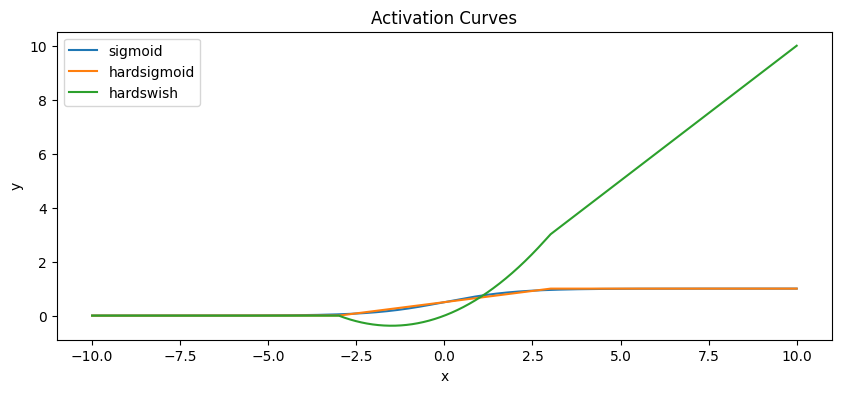

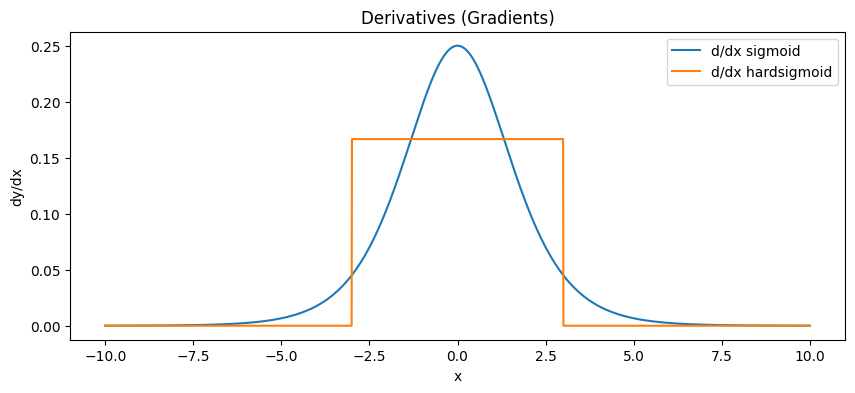

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Görsel karşılaştırma için aralık
x = torch.linspace(-10, 10, steps=2000)

sig = torch.sigmoid(x)
hsig = F.hardsigmoid(x)  # PyTorch hard sigmoid
hsw = F.hardswish(x)     # PyTorch hard swish

# Türevleri (autograd) — dikkat: requires_grad gerekiyor
xg = x.clone().detach().requires_grad_(True)
sig_g = torch.sigmoid(xg)
hsig_g = F.hardsigmoid(xg)

sig_g.sum().backward(retain_graph=True)
dsig = xg.grad.clone().detach()
xg.grad.zero_()

hsig_g.sum().backward()
dhsig = xg.grad.clone().detach()

plt.figure(figsize=(10,4))
plt.plot(x.numpy(), sig.numpy(), label="sigmoid")
plt.plot(x.numpy(), hsig.numpy(), label="hardsigmoid")
plt.plot(x.numpy(), hsw.numpy(), label="hardswish")
plt.title("Activation Curves")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

plt.figure(figsize=(10,4))
plt.plot(x.numpy(), dsig.numpy(), label="d/dx sigmoid")
plt.plot(x.numpy(), dhsig.numpy(), label="d/dx hardsigmoid")
plt.title("Derivatives (Gradients)")
plt.xlabel("x")
plt.ylabel("dy/dx")
plt.legend()
plt.show()

## 6) PyTorch’ta kullanım

İki temel yol var:

### a) Functional API
- `torch.nn.functional.hardsigmoid(x)`
- `torch.nn.functional.hardswish(x)`

### b) Module API
- `torch.nn.Hardsigmoid()`
- `torch.nn.Hardswish()`

Pratikte:
- “Layer” olarak kullanacaksan `nn.Hardsigmoid()` daha temiz.
- Hızlı deneme için `F.hardsigmoid` yeterli.


In [2]:
import torch.nn as nn

m1 = nn.Hardsigmoid()
m2 = nn.Hardswish()

t = torch.tensor([-5.0, -3.0, -1.0, 0.0, 1.0, 3.0, 5.0])
print("x:", t.tolist())
print("Hardsigmoid:", m1(t).tolist())
print("Hardswish:", m2(t).tolist())


x: [-5.0, -3.0, -1.0, 0.0, 1.0, 3.0, 5.0]
Hardsigmoid: [0.0, 0.0, 0.3333333432674408, 0.5, 0.6666666865348816, 1.0, 1.0]
Hardswish: [-0.0, -0.0, -0.3333333432674408, 0.0, 0.6666666865348816, 3.0, 5.0]


## 7) “Gating” örneği: SE/attention benzeri kapı

CNN’lerde çok sık “kanal ağırlığı” üretip feature map ile çarparsın:
- Sigmoid ile de yapılır
- HardSigmoid ile de yapılır

HardSigmoid’in avantajı:
- Mobil/edge hedeflerinde daha “hafif” bir gate

Aşağıda çok küçük bir örnek: channel gate üretip input’u ölçekliyoruz.


In [3]:
class SimpleGate(nn.Module):
    def __init__(self, channels: int, gate="hardsigmoid"):
        super().__init__()
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Conv2d(channels, channels, kernel_size=1, bias=True)
        if gate == "sigmoid":
            self.gate = torch.sigmoid
        elif gate == "hardsigmoid":
            self.gate = F.hardsigmoid
        else:
            raise ValueError("gate must be 'sigmoid' or 'hardsigmoid'")

    def forward(self, x):
        w = self.gate(self.fc(self.pool(x)))
        return x * w

x = torch.randn(2, 16, 32, 32)
g_sig = SimpleGate(16, gate="sigmoid")
g_hsig = SimpleGate(16, gate="hardsigmoid")

y1 = g_sig(x)
y2 = g_hsig(x)

print("Output shapes:", y1.shape, y2.shape)
print("Mean abs diff between gates:", (y1 - y2).abs().mean().item())


Output shapes: torch.Size([2, 16, 32, 32]) torch.Size([2, 16, 32, 32])
Mean abs diff between gates: 0.03344728797674179


## 8) Mini Deney: Sigmoid vs HardSigmoid ile eğitim davranışı (oyuncak ama öğretici)

Aşağıda küçük bir MLP ile basit bir ikili sınıflandırma problemi çözüyoruz.
Amaç:
- Sigmoid gate ile HardSigmoid gate arasındaki farkların “kabaca” görülmesi
- Bu bir benchmark değildir; sezgiyi güçlendirir.

> Gerçek CNN projelerinde farklar dataset ve mimariye göre değişir.


In [4]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

torch.manual_seed(0)

# Basit sentetik veri: iki gauss kümesi
def make_data(n=2048):
    c0 = torch.randn(n//2, 2) * 0.8 + torch.tensor([-2.0, -1.0])
    c1 = torch.randn(n//2, 2) * 0.8 + torch.tensor([ 2.0,  1.0])
    X = torch.cat([c0, c1], dim=0)
    y = torch.cat([torch.zeros(n//2), torch.ones(n//2)], dim=0).long()
    idx = torch.randperm(n)
    return X[idx], y[idx]

X, y = make_data(4096)
Xtr, ytr = X[:3072], y[:3072]
Xte, yte = X[3072:], y[3072:]

class GateMLP(nn.Module):
    def __init__(self, gate="sigmoid"):
        super().__init__()
        self.fc1 = nn.Linear(2, 64)
        self.fc2 = nn.Linear(64, 64)
        self.out = nn.Linear(64, 2)
        self.gproj = nn.Linear(64, 64)  # gate weights
        if gate == "sigmoid":
            self.gate = torch.sigmoid
        elif gate == "hardsigmoid":
            self.gate = F.hardsigmoid
        else:
            raise ValueError

    def forward(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        g = self.gate(self.gproj(h))
        h = h * g
        return self.out(h)

def train_one(gate="sigmoid", epochs=20, lr=1e-3):
    model = GateMLP(gate=gate)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()

    def acc_fn(logits, y):
        return (logits.argmax(dim=1) == y).float().mean().item()

    hist = []
    for ep in range(1, epochs+1):
        model.train()
        opt.zero_grad()
        logits = model(Xtr)
        loss = loss_fn(logits, ytr)
        loss.backward()
        opt.step()

        model.eval()
        with torch.no_grad():
            te_logits = model(Xte)
            te_loss = loss_fn(te_logits, yte).item()
            te_acc = acc_fn(te_logits, yte)

        hist.append((loss.item(), te_loss, te_acc))
    return hist

hist_sig = train_one("sigmoid")
hist_hsig = train_one("hardsigmoid")

print("Final (sigmoid):   train_loss=%.4f test_loss=%.4f acc=%.4f" % hist_sig[-1])
print("Final (hardsig):   train_loss=%.4f test_loss=%.4f acc=%.4f" % hist_hsig[-1])


Final (sigmoid):   train_loss=0.3109 test_loss=0.2947 acc=0.9990
Final (hardsig):   train_loss=0.3320 test_loss=0.3183 acc=0.9971


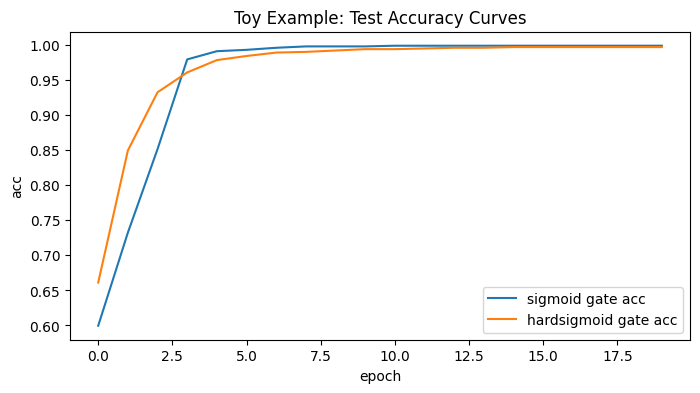

In [5]:
# Eğitim eğrilerini çizelim
import numpy as np
sig_acc = [h[2] for h in hist_sig]
hsig_acc = [h[2] for h in hist_hsig]

plt.figure(figsize=(8,4))
plt.plot(sig_acc, label="sigmoid gate acc")
plt.plot(hsig_acc, label="hardsigmoid gate acc")
plt.title("Toy Example: Test Accuracy Curves")
plt.xlabel("epoch")
plt.ylabel("acc")
plt.legend()
plt.show()


## 9) Hız (çok kaba) kıyas

CPU’da kaba bir kıyas yapacağız. Bu bir “bilimsel benchmark” değildir ama fikir verir.
GPU/CPU/dtype ve batch shape’e göre sonuç değişir.

> Ama genel eğilim: HardSigmoid genelde sigmoid’den daha ucuzdur (exp yok).


In [6]:
import time

def bench(fn, x, iters=2000, warmup=200):
    # warmup
    for _ in range(warmup):
        fn(x)
    t0 = time.perf_counter()
    for _ in range(iters):
        fn(x)
    t1 = time.perf_counter()
    return (t1 - t0) / iters

x = torch.randn(1024, 1024)

t_sig = bench(torch.sigmoid, x)
t_hsig = bench(F.hardsigmoid, x)
t_hsw = bench(F.hardswish, x)

print(f"avg time/iter sigmoid:     {t_sig*1e3:.3f} ms")
print(f"avg time/iter hardsigmoid: {t_hsig*1e3:.3f} ms")
print(f"avg time/iter hardswish:   {t_hsw*1e3:.3f} ms")


avg time/iter sigmoid:     0.240 ms
avg time/iter hardsigmoid: 0.079 ms
avg time/iter hardswish:   0.071 ms


## 10) Ne zaman kullanılır? (net karar rehberi)

### ✅ Mantıklı olduğu yerler
- Mobil/edge deployment hedefi (hafif gating)
- HardSwish kullanıyorsan zaten “içeride” var
- Attention / SE benzeri gating’de daha hafif alternatif

### ⚠️ Dikkat edilmesi gerekenler
- Uç bölgelerde gradyan **tam 0** → bazı durumlarda öğrenmeyi kilitleyebilir
- Çok agresif logit dağılımlarında gate doyguna çabuk gider

### ❌ Genelde tercih etmem
- Büyük modellerde saf accuracy peşindeysen (sigmoid bazen daha iyi)
- Gate’in çok hassas (smooth) davranması gerekiyorsa (sigmoid daha yumuşak)


## 11) Kısa özet 📌

- **HardSigmoid**, sigmoid’in parçalı doğrusal ve daha ucuz bir yaklaşımıdır.  
- Orta bölgede türevi sabit (**1/6**), uçlarda türev **0**.  
- Mobil mimarilerde, özellikle **HardSwish** ile birlikte, sık kullanılır.  
- Gating/attention benzeri mekanizmalarda inference maliyetini düşürmek için iyi bir araçtır.
